In [1]:
import pandas
import pyreadr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
transaction = pyreadr.read_r("/data/IDEA_DeFi_Research/Data/Lending_Protocols/Aave/V2/Mainnet/transactions.rds")
df = transaction[None]
df['DateTime'] = df['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
df.head()
# We are going to make a super basic linear model to try and predict how the AAVE token's price changes each day.
# This script will engineer one feature to use for this predictive task: dailyTransactionCount.

# To do this, we group the data by the date portion of the DateTime object, 
# and then simply count how many transactions are in each group
dailyTransactionCount = df.groupby([df['DateTime'].dt.date]).count()

In [3]:
# add borrow type to the dataframe
borrows = df[df['type'] == "borrow"]
dailyBorrowedAmountsUSD = borrows.groupby([borrows['DateTime'].dt.date]).sum()
dailyBorrowedAmountsUSD['amountBorrowedUSD'] = dailyBorrowedAmountsUSD['amountUSD']
dailyBorrowedAmountsUSD = dailyBorrowedAmountsUSD.filter(items = ['DateTime', 'amountBorrowedUSD'], axis = 'columns')
print(dailyBorrowedAmountsUSD)

            amountBorrowedUSD
DateTime                     
2020-12-01       1.001646e+00
2020-12-02       3.356704e+02
2020-12-03       7.422975e+05
2020-12-04       1.110540e+06
2020-12-05       1.344374e+06
...                       ...
2024-03-16       1.178125e+07
2024-03-17       1.267537e+07
2024-03-18       1.009068e+07
2024-03-19       2.301101e+07
2024-03-20       3.851585e+06

[1198 rows x 1 columns]


In [4]:
# add deposit type to the dataframe
deposits = df[df['type'] == "deposit"]
dailyDepositsAmountsUSD = deposits.groupby([deposits['DateTime'].dt.date]).sum()
dailyDepositsAmountsUSD['amountDepositsUSD'] = dailyDepositsAmountsUSD['amountUSD']
dailyDepositsAmountsUSD = dailyDepositsAmountsUSD.filter(items = ['DateTime', 'amountDepositsUSD'], axis = 'columns')
print(dailyDepositsAmountsUSD)

            amountDepositsUSD
DateTime                     
2020-11-30       9.359600e-02
2020-12-01       1.315362e+01
2020-12-02       1.197242e+04
2020-12-03       2.315446e+08
2020-12-04       2.570057e+08
...                       ...
2024-03-16       1.389962e+08
2024-03-17       4.796203e+07
2024-03-18       1.368484e+08
2024-03-19       3.058044e+08
2024-03-20       3.817089e+07

[1199 rows x 1 columns]


In [5]:
# add repay type to the dataframe
repays = df[df['type'] == "deposit"]
dailyRepaysAmountsUSD = repays.groupby([repays['DateTime'].dt.date]).sum()
dailyRepaysAmountsUSD['amountRepaysUSD'] = dailyRepaysAmountsUSD['amountUSD']
dailyRepaysAmountsUSD = dailyRepaysAmountsUSD.filter(items = ['DateTime', 'amountRepaysUSD'], axis = 'columns')
print(dailyRepaysAmountsUSD)

            amountRepaysUSD
DateTime                   
2020-11-30     9.359600e-02
2020-12-01     1.315362e+01
2020-12-02     1.197242e+04
2020-12-03     2.315446e+08
2020-12-04     2.570057e+08
...                     ...
2024-03-16     1.389962e+08
2024-03-17     4.796203e+07
2024-03-18     1.368484e+08
2024-03-19     3.058044e+08
2024-03-20     3.817089e+07

[1199 rows x 1 columns]


In [6]:
# add withdraw type to the dataframe
withdraws = df[df['type'] == "deposit"]
dailyWithdrawsAmountsUSD = withdraws.groupby([withdraws['DateTime'].dt.date]).sum()
dailyWithdrawsAmountsUSD['amountWithdrawsUSD'] = dailyWithdrawsAmountsUSD['amountUSD']
dailyWithdrawsAmountsUSD = dailyWithdrawsAmountsUSD.filter(items = ['DateTime', 'amountWithdrawsUSD'], axis = 'columns')
print(dailyWithdrawsAmountsUSD)

            amountWithdrawsUSD
DateTime                      
2020-11-30        9.359600e-02
2020-12-01        1.315362e+01
2020-12-02        1.197242e+04
2020-12-03        2.315446e+08
2020-12-04        2.570057e+08
...                        ...
2024-03-16        1.389962e+08
2024-03-17        4.796203e+07
2024-03-18        1.368484e+08
2024-03-19        3.058044e+08
2024-03-20        3.817089e+07

[1199 rows x 1 columns]


In [7]:
dailyTransactionCount = dailyTransactionCount[['id']]
dailyTransactionCount.rename(columns={"id": "transactionCount"}, inplace = True)
print(dailyTransactionCount)

            transactionCount
DateTime                    
2020-11-30                 3
2020-12-01                20
2020-12-02               205
2020-12-03              1089
2020-12-04               869
...                      ...
2024-03-16               451
2024-03-17               599
2024-03-18               459
2024-03-19               722
2024-03-20               283

[1202 rows x 1 columns]


In [8]:
# We load the minutely Aave price data here:
aavePrices = pandas.read_csv('/data/IDEA_DeFi_Research/Data/Coin_Prices/Minutely/aavePrices.csv')
# And here, since we want to predict daily prices, we create a new features which is the mean daily price.
aavePrices['DateTime'] = aavePrices['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
dailyMeanPrices = aavePrices.groupby([df['DateTime'].dt.date]).mean()
dailyMeanPrices = dailyMeanPrices[['priceUSD']]
print(dailyMeanPrices)

              priceUSD
DateTime              
2020-11-30  194.599095
2020-12-01  235.235688
2020-12-02  209.269302
2020-12-03  200.046567
2020-12-04  196.392221
...                ...
2024-03-16  133.579684
2024-03-17  145.518509
2024-03-18  145.331626
2024-03-19  131.623286
2024-03-20  147.553394

[1201 rows x 1 columns]


# Stage 2
In stage 2, our focus shifts towards feature engineering. The **dailyTransactionCount** now integrates four distinct types of data: deposit, withdraw, borrow, and repay. Meanwhile, we are currently deliberating on the best approach to incorporate the "liquidation" type data into the **dailyTransactionCount**.

In [9]:
# feature engineering, merge dailyTransactionCount, dailyMeanPrices, dailyBorrowedAmountsUSD
dailyTransactionCount = dailyTransactionCount.merge(dailyMeanPrices, how = "left", on = "DateTime")
dailyTransactionCount = dailyTransactionCount.merge(dailyBorrowedAmountsUSD, how = "left", on = "DateTime")
dailyTransactionCount = dailyTransactionCount.merge(dailyDepositsAmountsUSD, how = "left", on = "DateTime")
dailyTransactionCount = dailyTransactionCount.merge(dailyRepaysAmountsUSD, how = "left", on = "DateTime")
dailyTransactionCount = dailyTransactionCount.merge(dailyWithdrawsAmountsUSD, how = "left", on = "DateTime")
print(dailyTransactionCount)

            transactionCount    priceUSD  amountBorrowedUSD  \
DateTime                                                      
2020-11-30                 3  194.599095                NaN   
2020-12-01                20  235.235688       1.001646e+00   
2020-12-02               205  209.269302       3.356704e+02   
2020-12-03              1089  200.046567       7.422975e+05   
2020-12-04               869  196.392221       1.110540e+06   
...                      ...         ...                ...   
2024-03-16               451  133.579684       1.178125e+07   
2024-03-17               599  145.518509       1.267537e+07   
2024-03-18               459  145.331626       1.009068e+07   
2024-03-19               722  131.623286       2.301101e+07   
2024-03-20               283  147.553394       3.851585e+06   

            amountDepositsUSD  amountRepaysUSD  amountWithdrawsUSD  
DateTime                                                            
2020-11-30       9.359600e-02     9.359600

In [10]:
machine_learning_model_record = dict()

In [11]:
def data_split2(data_set):
    from sklearn.model_selection import TimeSeriesSplit
    # We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
    # column so in a given row, the transaction count is aligned with the next day's price.
    data_set['priceUSD_lead_1'] = data_set['priceUSD'].shift(-1)
    # We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
    data_set.dropna(inplace=True)
    # In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
    # percent change here by subtraction tomorrow's price from today's and dividing by today's price.
    data_set['dailyPercentChange'] = (data_set['priceUSD_lead_1'] - data_set['priceUSD']) / data_set['priceUSD']
    # We want to predict the direction of the daily percent change, so we create a new feature which is the sign of the daily percent change.
    data_set['directionOfDailyChange'] = np.sign(data_set['dailyPercentChange'])
    print(data_set)
    tss = TimeSeriesSplit(n_splits = 3)
    X = data_set.drop(labels=['priceUSD_lead_1', 'dailyPercentChange', 'directionOfDailyChange'],axis=1)
    y = data_set['directionOfDailyChange']
    for train_index, test_index in tss.split(data_set):
        feature_train, feature_test = X.iloc[train_index, :], X.iloc[test_index,:]
        target_train, target_test = y.iloc[train_index], y.iloc[test_index]
    return [feature_train, feature_test, target_train, target_test]

In [12]:
def plot_ground_truth(predictions, target_test_vals):
    # We plot the ground-truth values in blue and the predicted values in red:
    plt.plot(target_test_vals, color = "blue")
    plt.plot(predictions, color = "red")

In [13]:
def plot_difference(predictions, y_test_vals):
    # We plot the difference between our model's predictions and the actual values:
    plt.plot(y_test_vals - predictions)

In [14]:
def logistic_regression_model(feature_train, feature_test, target_train, target_test):
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report
    estimator = LogisticRegression(C = 1.0, penalty = "l2", solver = "liblinear", fit_intercept=True, max_iter=1000)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    # make record for the accuracy
    machine_learning_model_record["logistic_regression"] = estimator.score(feature_test, target_test) * 100
    # classification report for the logistic regression model
    report = classification_report(target_test, target_predict, labels=[2, 4], target_names=["Up", "Down"], zero_division=1)
    print(report)
    return predictions, target_test_vals

In [15]:
# logistic_regression run
feature_train, feature_test, target_train, target_test = data_split2(dailyTransactionCount)
predictions, target_test_vals = logistic_regression_model(feature_train, feature_test, target_train, target_test)

            transactionCount    priceUSD  amountBorrowedUSD  \
DateTime                                                      
2020-12-01                20  235.235688       1.001646e+00   
2020-12-02               205  209.269302       3.356704e+02   
2020-12-03              1089  200.046567       7.422975e+05   
2020-12-04               869  196.392221       1.110540e+06   
2020-12-05              1058  192.979787       1.344374e+06   
...                      ...         ...                ...   
2024-03-15               623  142.665923       3.142798e+07   
2024-03-16               451  133.579684       1.178125e+07   
2024-03-17               599  145.518509       1.267537e+07   
2024-03-18               459  145.331626       1.009068e+07   
2024-03-19               722  131.623286       2.301101e+07   

            amountDepositsUSD  amountRepaysUSD  amountWithdrawsUSD  \
DateTime                                                             
2020-12-01       1.315362e+01     1.3153

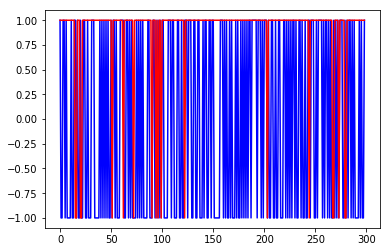

In [16]:
plot_ground_truth(predictions, target_test_vals)

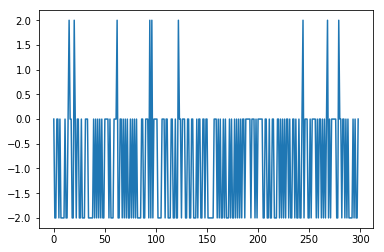

In [17]:
plot_difference(predictions, target_test_vals)

In [18]:
def knn_model(feature_train, feature_test, target_train, target_test):
    from sklearn.neighbors import KNeighborsClassifier
    estimator = KNeighborsClassifier(n_neighbors=3)
    estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = estimator.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    # make record for the accuracy
    machine_learning_model_record["knn"] = estimator.score(feature_test, target_test) * 100
    return predictions, target_test_vals

In [19]:
# knn_model run
feature_train, feature_test, target_train, target_test = data_split2(dailyTransactionCount)
predictions, target_test_vals = knn_model(feature_train, feature_test, target_train, target_test)

            transactionCount    priceUSD  amountBorrowedUSD  \
DateTime                                                      
2020-12-01                20  235.235688       1.001646e+00   
2020-12-02               205  209.269302       3.356704e+02   
2020-12-03              1089  200.046567       7.422975e+05   
2020-12-04               869  196.392221       1.110540e+06   
2020-12-05              1058  192.979787       1.344374e+06   
...                      ...         ...                ...   
2024-03-14               460  137.730236       5.320530e+06   
2024-03-15               623  142.665923       3.142798e+07   
2024-03-16               451  133.579684       1.178125e+07   
2024-03-17               599  145.518509       1.267537e+07   
2024-03-18               459  145.331626       1.009068e+07   

            amountDepositsUSD  amountRepaysUSD  amountWithdrawsUSD  \
DateTime                                                             
2020-12-01       1.315362e+01     1.3153

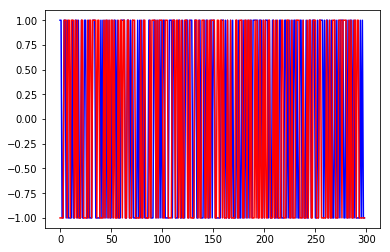

In [20]:
plot_ground_truth(predictions, target_test_vals)

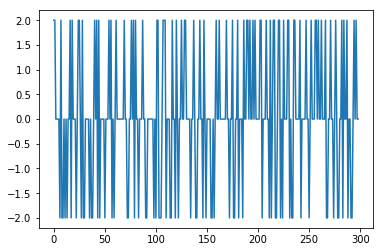

In [21]:
plot_difference(predictions, target_test_vals)

In [22]:
def knn_model_gridSearchCV(feature_train, feature_test, target_train, target_test):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler
    transfer = StandardScaler()
    # train data standardization
    feature_train = transfer.fit_transform(feature_train)
    feature_test = transfer.transform(feature_test)
    estimator = KNeighborsClassifier(n_neighbors=3, weights="uniform", algorithm="auto", leaf_size=30, p=2, metric="minkowski", metric_params=None, n_jobs=None)
    # KNN model optimization
    estimator = KNeighborsClassifier()
    parameters_testcase = {"n_neighbors": [3, 5, 7, 9, 11, 13]}
    estimator = GridSearchCV(estimator, parameters_testcase, cv=3)
    estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = estimator.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    # make record for the accuracy
    machine_learning_model_record["knn_gridSearch"] = estimator.score(feature_test, target_test) * 100
    return predictions, target_test_vals

In [23]:
# knn_model_gridSearchCV run
feature_train, feature_test, target_train, target_test = data_split2(dailyTransactionCount)
predictions, target_test_vals = knn_model_gridSearchCV(feature_train, feature_test, target_train, target_test)

            transactionCount    priceUSD  amountBorrowedUSD  \
DateTime                                                      
2020-12-01                20  235.235688       1.001646e+00   
2020-12-02               205  209.269302       3.356704e+02   
2020-12-03              1089  200.046567       7.422975e+05   
2020-12-04               869  196.392221       1.110540e+06   
2020-12-05              1058  192.979787       1.344374e+06   
...                      ...         ...                ...   
2024-03-13               388  152.105725       9.533228e+06   
2024-03-14               460  137.730236       5.320530e+06   
2024-03-15               623  142.665923       3.142798e+07   
2024-03-16               451  133.579684       1.178125e+07   
2024-03-17               599  145.518509       1.267537e+07   

            amountDepositsUSD  amountRepaysUSD  amountWithdrawsUSD  \
DateTime                                                             
2020-12-01       1.315362e+01     1.3153

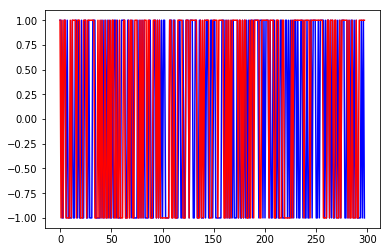

In [24]:
plot_ground_truth(predictions, target_test_vals)

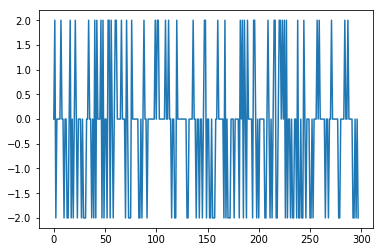

In [25]:
plot_difference(predictions, target_test_vals)

In [26]:
def multinomialNB_model(feature_train, feature_test, target_train, target_test):
    from sklearn.naive_bayes import MultinomialNB
    estimator = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    # make record for the accuracy
    machine_learning_model_record["naive_bayes"] = estimator.score(feature_test, target_test) * 100
    return predictions, target_test_vals

In [27]:
# naive bayes classifier
feature_train, feature_test, target_train, target_test = data_split2(dailyTransactionCount)
predictions, target_test_vals = multinomialNB_model(feature_train, feature_test, target_train, target_test)

            transactionCount    priceUSD  amountBorrowedUSD  \
DateTime                                                      
2020-12-01                20  235.235688       1.001646e+00   
2020-12-02               205  209.269302       3.356704e+02   
2020-12-03              1089  200.046567       7.422975e+05   
2020-12-04               869  196.392221       1.110540e+06   
2020-12-05              1058  192.979787       1.344374e+06   
...                      ...         ...                ...   
2024-03-12               604  153.722403       3.170201e+07   
2024-03-13               388  152.105725       9.533228e+06   
2024-03-14               460  137.730236       5.320530e+06   
2024-03-15               623  142.665923       3.142798e+07   
2024-03-16               451  133.579684       1.178125e+07   

            amountDepositsUSD  amountRepaysUSD  amountWithdrawsUSD  \
DateTime                                                             
2020-12-01       1.315362e+01     1.3153

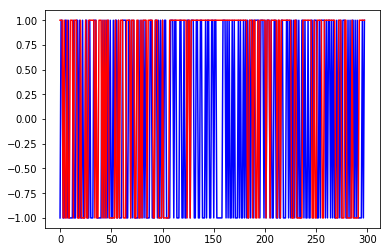

In [28]:
plot_ground_truth(predictions, target_test_vals)

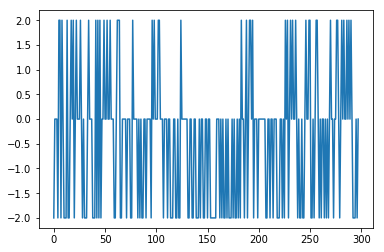

In [29]:
plot_difference(predictions, target_test_vals)

In [30]:
def decision_tree_model(feature_train, feature_test, target_train, target_test):
    from sklearn.tree import DecisionTreeClassifier
    estimator = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0)
    fit = estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = fit.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    # make record for the accuracy
    machine_learning_model_record["decision_tree"] = estimator.score(feature_test, target_test) * 100
    return predictions, target_test_vals

In [31]:
# decision tree model
feature_train, feature_test, target_train, target_test = data_split2(dailyTransactionCount)
predictions, target_test_vals = decision_tree_model(feature_train, feature_test, target_train, target_test)

            transactionCount    priceUSD  amountBorrowedUSD  \
DateTime                                                      
2020-12-01                20  235.235688       1.001646e+00   
2020-12-02               205  209.269302       3.356704e+02   
2020-12-03              1089  200.046567       7.422975e+05   
2020-12-04               869  196.392221       1.110540e+06   
2020-12-05              1058  192.979787       1.344374e+06   
...                      ...         ...                ...   
2024-03-11               692  161.745868       3.225463e+07   
2024-03-12               604  153.722403       3.170201e+07   
2024-03-13               388  152.105725       9.533228e+06   
2024-03-14               460  137.730236       5.320530e+06   
2024-03-15               623  142.665923       3.142798e+07   

            amountDepositsUSD  amountRepaysUSD  amountWithdrawsUSD  \
DateTime                                                             
2020-12-01       1.315362e+01     1.3153

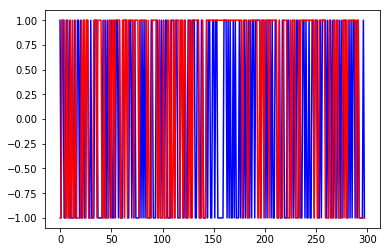

In [32]:
plot_ground_truth(predictions, target_test_vals)

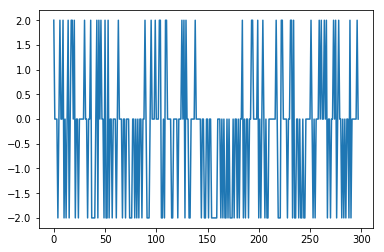

In [33]:
plot_difference(predictions, target_test_vals)

In [34]:
def random_forest_model(feature_train, feature_test, target_train, target_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    estimator = RandomForestClassifier()
    param_dict = {"n_estimators": [120,200,300,500,800,1200], "max_depth": [5,8,15,25,30]}
    estimator = GridSearchCV(estimator, param_grid=param_dict, cv=3)
    estimator.fit(feature_train, target_train)
    # We compute the predictions for the feature_test features:
    predictions = estimator.predict(feature_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - target_test) / len(target_test)
    target_test_vals = list()
    for data in target_test:
        target_test_vals.append(data)
    # model evaluation
    target_predict = estimator.predict(feature_test)
    print("The target_predict is:\n", target_predict)
    print("Compare predicted results with actual values:\n", target_predict == target_test)
    print("Accuracy:\n{0:.2f}%".format(estimator.score(feature_test, target_test) * 100))
    # make record for the accuracy
    machine_learning_model_record["decision_tree"] = estimator.score(feature_test, target_test) * 100
    return predictions, target_test_vals

In [35]:
# random forest model
feature_train, feature_test, target_train, target_test = data_split2(dailyTransactionCount)
predictions, target_test_vals = random_forest_model(feature_train, feature_test, target_train, target_test)

            transactionCount    priceUSD  amountBorrowedUSD  \
DateTime                                                      
2020-12-01                20  235.235688       1.001646e+00   
2020-12-02               205  209.269302       3.356704e+02   
2020-12-03              1089  200.046567       7.422975e+05   
2020-12-04               869  196.392221       1.110540e+06   
2020-12-05              1058  192.979787       1.344374e+06   
...                      ...         ...                ...   
2024-03-10               306  173.338523       1.104892e+07   
2024-03-11               692  161.745868       3.225463e+07   
2024-03-12               604  153.722403       3.170201e+07   
2024-03-13               388  152.105725       9.533228e+06   
2024-03-14               460  137.730236       5.320530e+06   

            amountDepositsUSD  amountRepaysUSD  amountWithdrawsUSD  \
DateTime                                                             
2020-12-01       1.315362e+01     1.3153

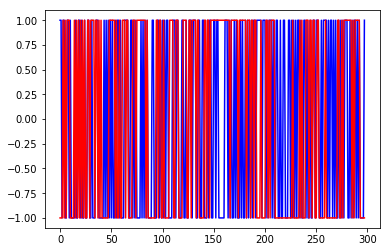

In [36]:
plot_ground_truth(predictions, target_test_vals)

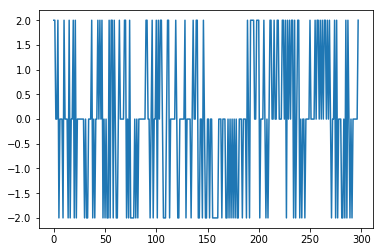

In [37]:
plot_difference(predictions, target_test_vals)

In [38]:
# model accuracy record
for i in machine_learning_model_record.keys():
    print("The accuracy of model: {} is {:.2f}%\n".format(i, machine_learning_model_record.get(i)))

The accuracy of model: logistic_regression is 48.83%

The accuracy of model: knn is 53.51%

The accuracy of model: knn_gridSearch is 56.04%

The accuracy of model: naive_bayes is 49.33%

The accuracy of model: decision_tree is 48.66%

